# Bi-Est-Python
>Semi-supervised modeling of mixture of mixtures of multivariate gaussians

Given an unbiased unlabeled sample and labeled biased positive and negative samples, estiamte the distributions of the three samples. The biased positive and negative distributions are assumed to share the same components of the unbiased positive and negative distributions but with different component mixture weights as discussed in [1]. Support has been added for handling noisy positive and negative biased samples by providing score estimates for the instances that approximate the posterior. Additionally, one can choose whether to assing equal importance to each instance or each sample.

[1] De Paolis Kaluza, M. Clara, Shantanu Jain, and Predrag Radivojac. "An Approach to Identifying and Quantifying Bias in Biomedical Data." PACIFIC SYMPOSIUM ON BIOCOMPUTING 2023: Kohala Coast, Hawaii, USA, 3–7 January 2023. 2022.

## Installation
`pip install bi_est_python`

# Demo

In [1]:
import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt

from bi_est_python.pnu_em import PNU_EM
from scipy.special import expit
# from bi_est_python.Mixture import NMixture, PUMixture

In [2]:
plt.set_loglevel (level = 'error')


In [3]:
class ParamSet():
    def __init__(self,*args, **kwargs):
        self.__dict__.update(kwargs)


In [24]:
from scipy.stats import norm
fP1 = norm(loc=6,scale=1)
fP2 = norm(loc=2,scale=1)
fB1 = norm(loc=-6,scale=1)
fB2 = norm(loc=-2,scale=1)

trueParams = ParamSet(prior = .25,
                        w_pos = [.35, .65],
                        v_pos = [.25,.75],
                        w_neg = [.45, .55],
                        v_neg = [.5,.5])

def get_posterior(x):
    f1 = trueParams.prior * (trueParams.w_pos[0] * fP1.pdf(x) + trueParams.w_pos[1] * fP2.pdf(x))
    f0 = (1-trueParams.prior) * (trueParams.w_neg[0] * fB1.pdf(x) + trueParams.w_neg[1] * fB2.pdf(x))
    return f1 / (f1 + f0)

NLabeledPos = 500
NNoisyLabeledPos = 10
NLabeledNeg = 500
NNoisyLabeledNeg = 10
n_unlabeled = 10000

labeled_pos = np.concatenate((fP1.rvs(int(np.round(NLabeledPos * trueParams.v_pos[0]))),
                            fP2.rvs(int(np.round(NLabeledPos * trueParams.v_pos[1]))),
                            fB1.rvs(NNoisyLabeledPos)))
scores_labeled_pos = get_posterior(labeled_pos)

labeled_neg = np.concatenate((fB1.rvs(int(np.round(trueParams.v_neg[0] * NLabeledNeg))),
                                fB2.rvs(int(np.round(trueParams.v_neg[1] * NLabeledNeg))),
                                fP1.rvs(NNoisyLabeledNeg)))
scores_labeled_neg = get_posterior(labeled_neg)

unlabeled_data = np.concatenate((fP1.rvs(int(np.round(n_unlabeled * trueParams.prior * trueParams.w_pos[0]))),
                                    fP2.rvs(int(np.round(n_unlabeled * trueParams.prior * trueParams.w_pos[1]))),
                                    fB1.rvs(int(np.round(n_unlabeled * (1-trueParams.prior) * trueParams.w_neg[0]))),
                                    fB2.rvs(int(np.round(n_unlabeled * (1-trueParams.prior) * trueParams.w_neg[1])))))
scores_unlabeled = get_posterior(unlabeled_data)


<Axes: ylabel='Count'>

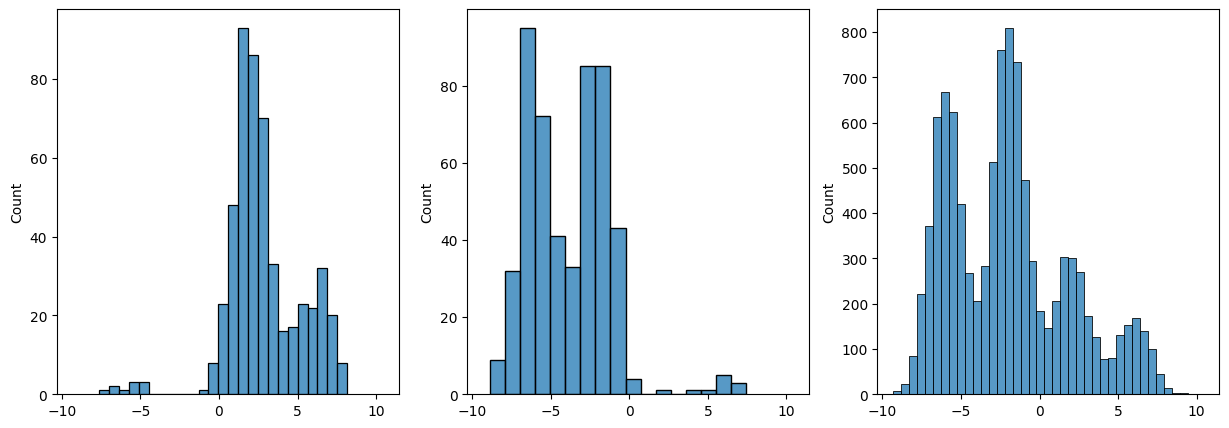

In [25]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharex=True)
sns.histplot(labeled_pos,ax=ax[0])
sns.histplot(labeled_neg,ax=ax[1])
sns.histplot(unlabeled_data,ax=ax[2])

In [30]:
em = PNU_EM(n_components=2,max_steps=500,tol=1e-5)

In [31]:

em.fit(labeled_pos[...,None], labeled_neg[...,None],unlabeled_data[...,None],weighting_scheme='sample',
        scores_labeled_neg=scores_labeled_neg, scores_labeled_pos=scores_labeled_pos)#,
        # scores_unlabeled=scores_unlabeled)

Initial Parameters:
alpha: 0.2567,

mu_pos: [[5.9222]
 [1.8917]],

cov_pos: [[[1.0603]]

 [[0.9646]]],

w_pos: [[0.3541]
 [0.6459]],

v_pos: [[0.7392]
 [0.2608]],

mu_neg: [[-2.0017]
 [-6.0023]],

cov_neg: [[[0.8167]]

 [[0.9197]]],

w_neg: [[0.543]
 [0.457]],

v_neg: [[0.502]
 [0.498]],

Step 1 log-likelihood: -21063.650334524682
Step 2 log-likelihood: -21066.44977430434
Step 3 log-likelihood: -21077.21134963537
Step 4 log-likelihood: -21080.70685305248
Step 5 log-likelihood: -21078.90067757414
Step 6 log-likelihood: -21077.378589301643
Step 7 log-likelihood: -21076.315516213628
Step 8 log-likelihood: -21075.548520305027
Step 9 log-likelihood: -21074.986145522562
Step 10 log-likelihood: -21074.570955360283
Step 10 Params
alpha: 0.2445,

mu_pos: [[5.9881]
 [2.0681]],

cov_pos: [[[1.1097]]

 [[0.7412]]],

w_pos: [[0.3703]
 [0.6297]],

v_pos: [[0.2713]
 [0.7287]],

mu_neg: [[-2.028]
 [-6.014]],

cov_neg: [[[0.9434]]

 [[1.0404]]],

w_neg: [[0.5514]
 [0.4486]],

v_neg: [[0.4941]
 [0.5059]

INFO:root:EM algorithm converged after 41 steps in 55.190332651138306 seconds.


Step 41 log-likelihood: -21073.416820258397
alpha: 0.2447,

mu_pos: [[6.0194]
 [2.078 ]],

cov_pos: [[[1.0544]]

 [[0.7571]]],

w_pos: [[0.3645]
 [0.6355]],

v_pos: [[0.2674]
 [0.7326]],

mu_neg: [[-2.029 ]
 [-6.0147]],

cov_neg: [[[0.9436]]

 [[1.0392]]],

w_neg: [[0.5514]
 [0.4486]],

v_neg: [[0.4943]
 [0.5057]],



In [32]:
em.log_params()

alpha: 0.2447,

mu_pos: [[6.0194]
 [2.078 ]],

cov_pos: [[[1.0544]]

 [[0.7571]]],

w_pos: [[0.3645]
 [0.6355]],

v_pos: [[0.2674]
 [0.7326]],

mu_neg: [[-2.029 ]
 [-6.0147]],

cov_neg: [[[0.9436]]

 [[1.0392]]],

w_neg: [[0.5514]
 [0.4486]],

v_neg: [[0.4943]
 [0.5057]],



In [33]:
trueParams.__dict__

{'prior': 0.25,
 'w_pos': [0.35, 0.65],
 'v_pos': [0.25, 0.75],
 'w_neg': [0.45, 0.55],
 'v_neg': [0.5, 0.5]}